In [1]:
# Import dependent modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import string
import h5py
import matplotlib
from collections import Counter
import tensorflow as tf
%matplotlib inline
pixel_depth = 255.0
screen_width = 800
screen_height = 600

In [7]:
# Prepare the pickle file of digitstruct files

In [5]:
def get_attr(c, i, attr):
    d = c[c['digitStruct']['bbox'][i][0]][attr].value.squeeze()
    if d.dtype == 'float64':
        return d.reshape(-1)
    return np.array([c[x].value for x in d]).squeeze()

def get_label(c, i):
    d = c[c['digitStruct']['name'][i][0]].value.tostring()
    
    return d.replace('\x00', '')

def load_data(path, n):
    c = h5py.File(path)
    if n == 0:
        n = c['digitStruct']['name'].shape[0]
    images = a = np.ndarray(shape=(n, ), dtype='|S15')
    labels = np.zeros((n, 6), dtype=float)
    labels.fill(11)
    tops = np.zeros((n, 6), dtype=float)
    heights = np.zeros((n, 6), dtype=float)
    widths = np.zeros((n, 6), dtype=float)
    lefts = np.zeros((n, 6), dtype=float)
    
    for i in range(n):
        images[i] = get_label(c, i)
        l = get_attr(c, i, 'label')
        t = get_attr(c, i, 'top')
        h = get_attr(c, i, 'height')
        w = get_attr(c, i, 'width')
        le = get_attr(c, i, 'left')
        l
        labels[i, :l.shape[0]] = l
        tops[i, :t.shape[0]] = t
        heights[i, :h.shape[0]] = h
        widths[i, :w.shape[0]] = w
        lefts[i, :le.shape[0]] = le
    
        if (i % 5000 == 0):
            print(i, "elapsed")
    
    return labels, images, tops, heights, widths, lefts
extra__tuple = load_data('extra/digitStruct.mat', 95000)
train__tuple = load_data('train/digitStruct.mat', 0)
test__tuple = load_data('test/digitStruct.mat', 0)

def maybe_pickle(struct, force=False):
    if os.path.exists(struct + '.pickle') and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % struct)
    else:
      print('Pickling %s.' % struct + '.pickle')
      dataset = {
            'train': {
                'labels': train__tuple[0],
                'images': train__tuple[1],  
                'tops': train__tuple[2],
                'heights': train__tuple[3],
                'widths': train__tuple[4],
                'lefts': train__tuple[5],
            }, 
            'test': {
                'labels': test__tuple[0],
                'images': test__tuple[1],  
                'tops': test__tuple[2],
                'heights': test__tuple[3],
                'widths': test__tuple[4],
                'lefts': test__tuple[5],
            },
            'extra': {
                'labels': extra__tuple[0],
                'images': extra__tuple[1],  
                'tops': extra__tuple[2],
                'heights': extra__tuple[3],
                'widths': extra__tuple[4],
                'lefts': extra__tuple[5],
            }
            }
      try:
        with open( struct + '.pickle', 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to',  struct + '.pickle', ':', e)
    return  struct + '.pickle'
maybe_pickle('svhn', True)


[<HDF5 object reference> <HDF5 object reference> <HDF5 object reference>] [[<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]]
(0, 'elapsed')
[<HDF5 object reference> <HDF5 object reference>] [[<HDF5 object reference>]
 [<HDF5 object reference>]]
[<HDF5 object reference> <HDF5 object reference> <HDF5 object reference>] [[<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]]
[<HDF5 object reference> <HDF5 object reference>] [[<HDF5 object reference>]
 [<HDF5 object reference>]]
[<HDF5 object reference> <HDF5 object reference> <HDF5 object reference>] [[<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]]
[<HDF5 object reference> <HDF5 object reference>] [[<HDF5 object reference>]
 [<HDF5 object reference>]]
[<HDF5 object reference> <HDF5 object reference> <HDF5 object reference>] [[<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]]
[<HDF5 object reference> <HDF5 object referenc

KeyboardInterrupt: 

In [5]:
# Prepare pretraining data for the Convolutional auto encoder

In [3]:
from scipy.misc import imresize
def prep(arr):
    d = [x for x in arr if x != 0]
    if d == []:
        return 0
    else:
        return min(d)
try:
    with open('svhn.pickle', 'rb') as f:
        dataset = pickle.load(f)
except Exception as e:
    print('Unable to process data from dataset.pickle', ':', e)
    raise
def load_image(image_file, path='train/', **box):
    image_data = np.average(ndimage.imread(path+image_file), axis=2)
    if box['minTop'] <= 0:
        box['minTop'] = 0
    if box['minLeft'] <= 0:
        box['minLeft'] = 0
    image_data = image_data[box['minTop']:box['maxTopHeight'], box['minLeft']:box['maxLeftWidth']]
    image_data = imresize(image_data, (32,32))      
    image_data = (image_data.astype(float) - pixel_depth / 2) / pixel_depth
    return image_data

def load_images(dataset, struct):
    new_y = []
    images = np.array(dataset[struct]['images'])
    tops = dataset[struct]['tops']
    widths = dataset[struct]['widths']
    heights = dataset[struct]['heights']
    lefts = dataset[struct]['lefts']
    data = []
    k = 0
    for i in range(images.shape[0]):
        if (i % 5000 == 0):
            print(i, "elapsed out of ", images.shape[0], "for: ", struct)
        try:
            if struct == 'valid':
                path = 'extra/'
            else:
                path = struct + '/'
            chrCount = 4
            topHeights = np.array([tops[i][:chrCount], heights[i][:chrCount]])
            leftWidths = np.array([lefts[i][:chrCount], widths[i][:chrCount]])
            minTop = prep(topHeights[0, :])
            minLeft = leftWidths[0, 0]
            maxTop = topHeights.sum(axis=0).max()
            maxLeft = leftWidths.sum(axis=0).max()
            leftWidths = leftWidths.sum(axis=0).tolist()
            length = leftWidths.index(np.max(leftWidths)) + 1
            if length != 4:
                avgWidth = (maxLeft - minLeft)/ length
                maxLeft = maxLeft + int((4 - length) * avgWidth)
            image = load_image(images[i], path, **{
                    "minTop": minTop,
                    "minLeft": minLeft,
                    "maxTopHeight": maxTop,
                    "maxLeftWidth": maxLeft
                })
            data.append(image)
            k += 1
            new_y.append(dataset[struct]['labels'][i])
        except Exception, e:
            img = np.average(ndimage.imread(path+images[i]), axis=2)
            print( i, chrCount,img.shape, {
                "minTop": min(topHeights[0, :]),
                "minLeft": min(leftWidths[1, :]),
                "maxTopHeight": topHeights.sum(axis=0).max(),
                "maxLeftWidth": leftWidths.sum(axis=0).max(),
                "lefts": lefts[i],
                "widths": widths[i],
                "message": e.message
            })
            return
    d = np.ndarray(shape = [k, 32, 32])
    i = 0
    for i, v in enumerate(data):
        d[i, :, :] = v
    return d, np.array(new_y)

trX, trY = load_images(dataset, 'train')
teX, teY = load_images(dataset, 'test')
exX, exY = load_images(dataset, 'extra')

(0, 'elapsed out of ', 33402, 'for: ', 'train')


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(5000, 'elapsed out of ', 33402, 'for: ', 'train')
(10000, 'elapsed out of ', 33402, 'for: ', 'train')
(15000, 'elapsed out of ', 33402, 'for: ', 'train')
(20000, 'elapsed out of ', 33402, 'for: ', 'train')
(25000, 'elapsed out of ', 33402, 'for: ', 'train')
(30000, 'elapsed out of ', 33402, 'for: ', 'train')
(0, 'elapsed out of ', 13068, 'for: ', 'test')
(5000, 'elapsed out of ', 13068, 'for: ', 'test')
(10000, 'elapsed out of ', 13068, 'for: ', 'test')
(0, 'elapsed out of ', 95000, 'for: ', 'extra')
(5000, 'elapsed out of ', 95000, 'for: ', 'extra')
(10000, 'elapsed out of ', 95000, 'for: ', 'extra')
(15000, 'elapsed out of ', 95000, 'for: ', 'extra')
(20000, 'elapsed out of ', 95000, 'for: ', 'extra')
(25000, 'elapsed out of ', 95000, 'for: ', 'extra')
(30000, 'elapsed out of ', 95000, 'for: ', 'extra')
(35000, 'elapsed out of ', 95000, 'for: ', 'extra')
(40000, 'elapsed out of ', 95000, 'for: ', 'extra')
(45000, 'elapsed out of ', 95000, 'for: ', 'extra')
(50000, 'elapsed out of ',

In [5]:
try:
    with open( 'pretrain.pickle', 'wb') as f:
        pickle.dump({
            'train': {'data': trX, 'label': trY},
            'test': {'data': teX, 'label': teY},
            'extra': {'data': exX, 'label': exY},
            }, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to',  struct + '.pickle', ':', e)

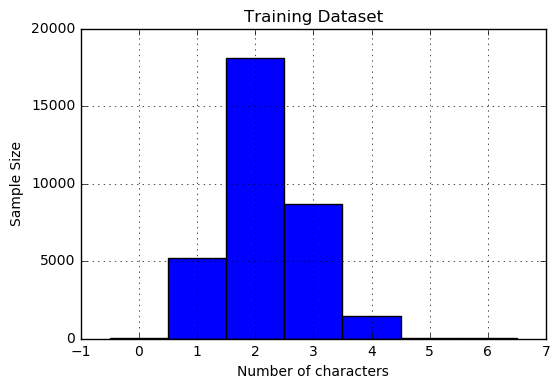

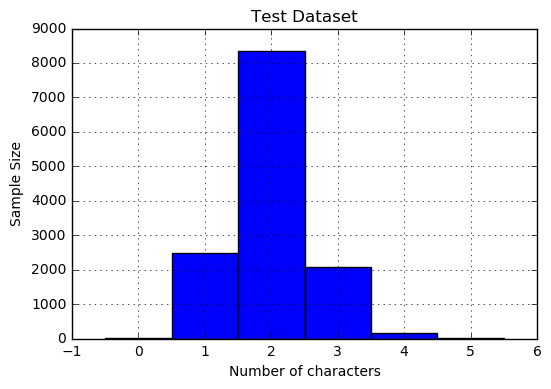

In [7]:
from collections import Counter
with open('svhn.pickle', 'r') as f:
    dataset = pickle.load(f)
c = Counter(np.sum(dataset["train"]["tops"] > 0, axis =1))
l = plt.bar(c.keys(), c.values(), 1, color="blue", align = 'center')

plt.xlabel('Number of characters')
plt.ylabel('Sample Size')
plt.grid(True)
plt.title('Training Dataset')

plt.show()

c = Counter(np.sum(dataset["test"]["tops"] > 0, axis =1))
l = plt.bar(c.keys(), c.values(), 1, color="blue", align = 'center')

plt.xlabel('Number of characters')
plt.ylabel('Sample Size')
plt.grid(True)
plt.title('Test Dataset')

plt.show()

In [8]:
np.std(np.max(dataset["test"]["heights"], axis=1)), np.mean(np.max(dataset["test"]["heights"], axis=1)), \
np.median(np.max(dataset["test"]["heights"], axis=1))

(13.45875541177187, 27.898607284970922, 24.0)

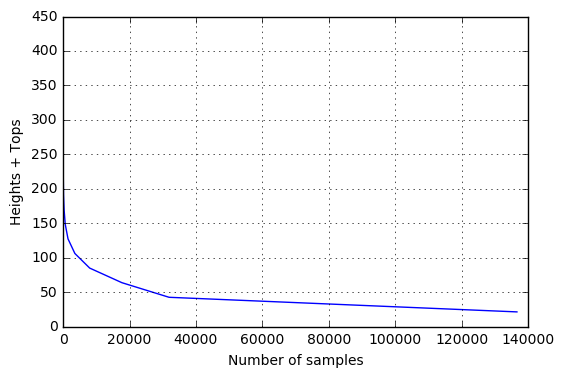

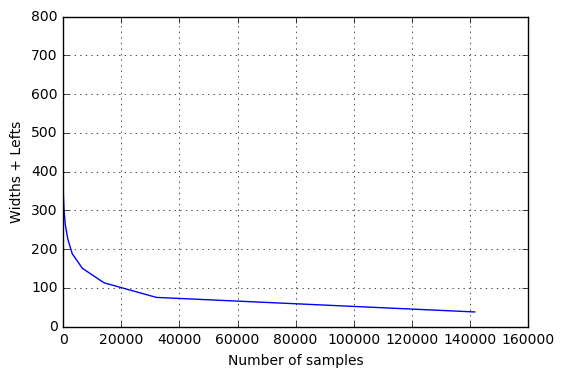

In [9]:
hist = np.histogram(dataset["train"]["heights"] +dataset["train"]["tops"], bins=20)
y = hist[1][1:]
l = plt.plot(hist[0][:], y, linewidth=1)

plt.xlabel('Number of samples')
plt.ylabel('Heights + Tops')
plt.grid(True)

plt.show()

hist = np.histogram(dataset["train"]["widths"] +dataset["train"]["lefts"], bins=20)
y = hist[1][1:]
l = plt.plot(hist[0][:], y, linewidth=1)

plt.xlabel('Number of samples')
plt.ylabel('Widths + Lefts')
plt.grid(True)

plt.show()

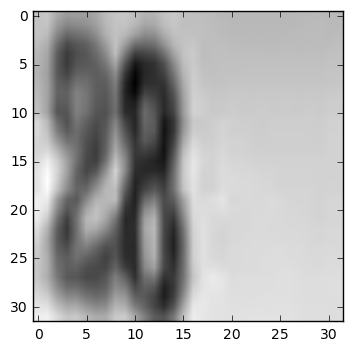

In [11]:
with open('pretrain.pickle', 'r') as f:
    pre_dataset = pickle.load(f)
from scipy.ndimage import filters
def magnitude_grad(x):
    imx = np.zeros(x.shape)
    filters.gaussian_filter(x, (5, 5), (0, 1), imx)
    imy = np.zeros(x.shape)
    filters.gaussian_filter(x, (5, 5), (1, 0), imy)
    magnitude = np.sqrt(imx**2 + imy**2)
    return magnitude
plt.imshow(pre_dataset['train']['data'][6], cmap = 'gray')


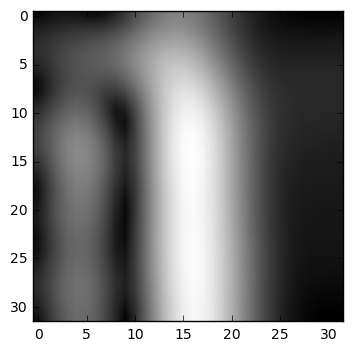

In [12]:
plt.imshow(magnitude_grad(pre_dataset['train']['data'][6]), cmap= 'gray')

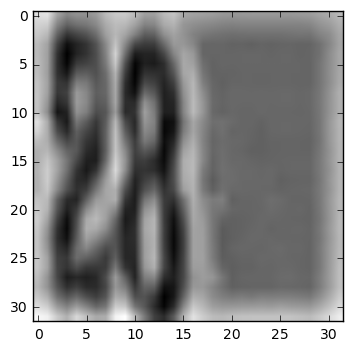

In [13]:
from utils import lcn
with tf.Session() as sess:
    img = lcn(pre_dataset['train']['data'][6:7].reshape(1, 32, 32, 1).astype(np.float32)).eval().reshape(32, 32)    
plt.imshow(img, cmap = 'gray')


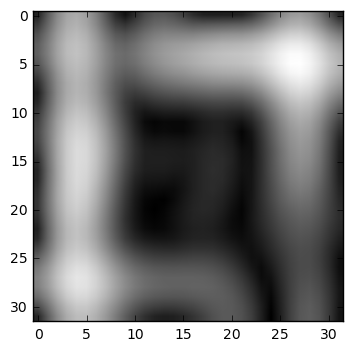

In [11]:
plt.imshow(magnitude_grad(img), cmap= 'gray')